# S&P 500 Signal Classifier

Approach:
1. Create features
2. Winsorize data
3. Test, Train split data
4. Scale the test and train data
6. Original, Oversample, and Undersample the data
7. Apply RandomForestClassifier, XGBoost, and LightBoost to predict

## Install Required Packages

In [3]:
# Install Yahoo Finance
!pip install yfinance --upgrade --no-cache-dir

In [4]:
# Install SciKit Learn
!pip install scikit-learn

In [5]:
# Install XGBoost
!pip install xgboost

In [6]:
# Install LightBoost
!pip install lightgbm

## Import Required Dependencies

In [7]:
# Import the required libraries and dependencies
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score, make_scorer
from sklearn.model_selection import train_test_split
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from xgboost import XGBClassifier
from xgboost import plot_importance
import lightgbm as lgb

In [8]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Retrieve and Load Data

In [9]:
# Retreive data
sp500 = yf.Ticker('^GSPC')
sp500 = sp500.history(period='max')

In [10]:
# Drop timezone from datetime
sp500 = sp500.reset_index()
sp500['Date'] = sp500['Date'].dt.tz_localize(None)
sp500.set_index('Date', inplace=True)

In [11]:
# Get the last rows of the DataFrame
sp500 = sp500.tail(24252) # Get max available data

In [12]:
# Display data
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-06-25,5460.729980,5472.879883,5446.560059,5469.299805,3591960000,0.0,0.0
2024-06-26,5460.709961,5483.140137,5451.870117,5477.899902,3563920000,0.0,0.0
2024-06-27,5473.589844,5490.810059,5467.540039,5482.870117,3589530000,0.0,0.0


In [13]:
# Create stock df
stock_df = pd.DataFrame(sp500).dropna()
stock_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-06-25,5460.729980,5472.879883,5446.560059,5469.299805,3591960000,0.0,0.0
2024-06-26,5460.709961,5483.140137,5451.870117,5477.899902,3563920000,0.0,0.0
2024-06-27,5473.589844,5490.810059,5467.540039,5482.870117,3589530000,0.0,0.0


In [14]:
# Drop columns
stock_df.drop(columns={'Volume', 'Dividends', 'Stock Splits'}, inplace=True)

# Sort by ascending date
stock_df = stock_df.sort_values(by="Date", ascending=True)

# Review the first and last five rows of the DataFrame
display(stock_df.head())
display(stock_df.tail())

,Open,High,Low,Close
Date,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000
1928-01-03,17.760000,17.760000,17.760000,17.760000
1928-01-04,17.719999,17.719999,17.719999,17.719999
1928-01-05,17.549999,17.549999,17.549999,17.549999
1928-01-06,17.660000,17.660000,17.660000,17.660000


,Open,High,Low,Close
Date,,,,
2024-06-25,5460.729980,5472.879883,5446.560059,5469.299805
2024-06-26,5460.709961,5483.140137,5451.870117,5477.899902
2024-06-27,5473.589844,5490.810059,5467.540039,5482.870117
2024-06-28,5488.479980,5523.640137,5451.120117,5460.479980
2024-07-01,5471.080078,5479.549805,5446.529785,5475.089844


In [15]:
# Rename dataframe to data
data = stock_df

## Perform Feature Engineering

In [16]:
# Feature Engineering
# Moving Averages
data['SMA10'] = data['Close'].rolling(window=10).mean()
data['SMA20'] = data['Close'].rolling(window=20).mean()
data['SMA30'] = data['Close'].rolling(window=20).mean()
data['SMA50'] = data['Close'].rolling(window=50).mean()
data['SMA100'] = data['Close'].rolling(window=100).mean()
data['SMA200'] = data['Close'].rolling(window=200).mean()

# RSI
def rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data['RSI'] = rsi(data)

# MACD
data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA12'] - data['EMA26']
data['SL'] = data['MACD'].ewm(span=9, adjust=False).mean()

# Bollinger Bands
data['BollM'] = data['Close'].rolling(window=20).mean()
data['BollU'] = data['BollM'] + (2 * data['Close'].rolling(window=20).std())
data['BollL'] = data['BollM'] - (2 * data['Close'].rolling(window=20).std())

# Identify crossover signal for Target Column
# Close < Bollinger Mid and RSI < 50 and MACD < 0
data['Signal'] = np.where((data['Close'] < data['BollM']) & (data['RSI'] < 50) & (data['MACD'] < 0), 1, 0)

# Calculate return
data['Return'] = data['Close'].pct_change().shift(-1)  # Next day's return

# Label Data
# Buy ONLY if all Crossover conditions are met
# Assume profitable if return > 0%
data['Target'] = np.where((data['Signal'] > 0) & (data['Return'] > 0.0), 1, 0)

# Prepare dataset
features = ['SMA10', 'SMA20', 'SMA30', 'SMA50', 'SMA100', 'SMA200', 'RSI', 'MACD', 'SL', 'BollM', 'BollU', 'BollL']
dataset = data.dropna()[features + ['Target']]

## Perform Winsorization of Data

In [18]:
from scipy.stats.mstats import winsorize
dataset['SMA10'] = winsorize(np.array(dataset['SMA10']), limits=[.05, .05])
dataset['SMA20'] = winsorize(np.array(dataset['SMA20']), limits=[.05, .05])
dataset['SMA30'] = winsorize(np.array(dataset['SMA30']), limits=[.05, .05])
dataset['SMA50'] = winsorize(np.array(dataset['SMA50']), limits=[.05, .05])
dataset['SMA100'] = winsorize(np.array(dataset['SMA100']), limits=[.05, .05])
dataset['SMA200'] = winsorize(np.array(dataset['SMA200']), limits=[.05, .05])
dataset['MACD'] = winsorize(np.array(dataset['MACD']), limits=[.05, .05])
dataset['BollM'] = winsorize(np.array(dataset['BollM']), limits=[.05, .05])
dataset['BollU'] = winsorize(np.array(dataset['BollU']), limits=[.05, .05])
dataset['BollL'] = winsorize(np.array(dataset['BollL']), limits=[.05, .05])
dataset['SL'] = winsorize(np.array(dataset['SL']), limits=[.05, .05])

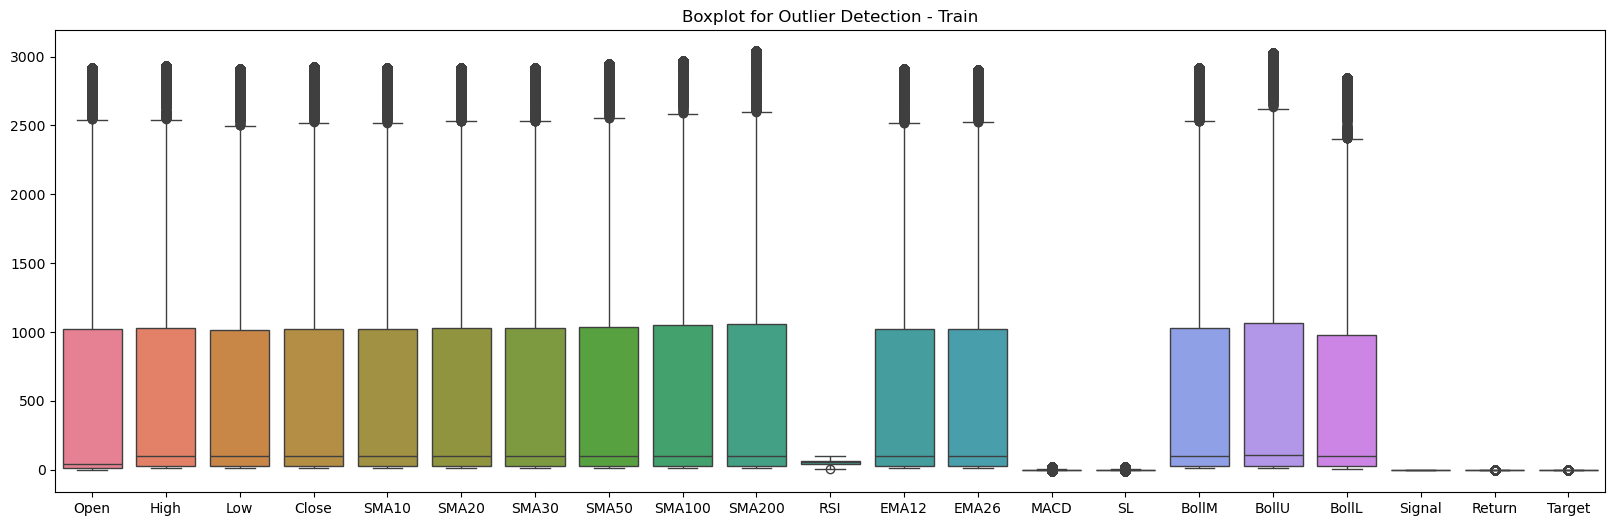

In [19]:
plt.figure(figsize=(20, 6))
sns.boxplot(dataset)
plt.title("Boxplot for Outlier Detection - Train")
plt.show()

## Perform Train and Test Splits

In [20]:
# Define train and test sets
X = dataset[features]
y = dataset['Target']

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Perform Scaling

In [23]:
# Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames to maintain column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

# Perform Classifications

## Original Scaled Data with Untuned RandomForestClassifier

In [24]:
# Define the model
clf = RandomForestClassifier(random_state=1)

# Fit the model
clf.fit(X_train_scaled, y_train)

# Predict using the model
train_pred = clf.predict(X_train_scaled)
test_pred = clf.predict(X_test_scaled)

# Generate classification report
# Print scores
print("Balanced Accuracy Scores")
print("--------------------------------------------------------")
x = balanced_accuracy_score(y_train, train_pred)
y = balanced_accuracy_score(y_test, test_pred)
print(balanced_accuracy_score(y_train, train_pred),'training')
print(balanced_accuracy_score(y_test, test_pred),'testing')
print(round((x-y), 16),'variance')

# Print classification reports
print("--------------------------------------------------------")
print(f"Classification Report")
report = classification_report(y_test, test_pred, zero_division=1)
print(report)
print("--------------------------------------------------------")

Balanced Accuracy Scores
--------------------------------------------------------
1.0 training
0.6233491705841372 testing
0.3766508294158628 variance
--------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      4245
           1       0.55      0.28      0.37       563

    accuracy                           0.89      4808
   macro avg       0.73      0.62      0.65      4808
weighted avg       0.87      0.89      0.87      4808

--------------------------------------------------------


## Over Sampled Scaled Data with Untuned RandomForestClassifier

In [25]:
# Import RandomOverSampler from imblearn
from imblearn.over_sampling import RandomOverSampler

# Instantiate a RandomOversampler instance
ros = RandomOverSampler(random_state=1)

# Fit the training data to the `RandomOverSampler` model
X_oversampled, y_oversampled = ros.fit_resample(X_train_scaled, y_train)

# Count distinct values
y_oversampled.value_counts()

0    16546
1    16546
Name: Target, dtype: int64

In [26]:
# Instantiate the model
ros_clf = RandomForestClassifier(random_state=1)

# Fit the model
ros_clf.fit(X_oversampled, y_oversampled)

# Predict using the model
train_pred = ros_clf.predict(X_train_scaled)
test_pred = ros_clf.predict(X_test_scaled)

# Generate classification report
# Print scores
print("Balanced Accuracy Scores")
print("--------------------------------------------------------")
x = balanced_accuracy_score(y_train, train_pred)
y = balanced_accuracy_score(y_test, test_pred)
print(balanced_accuracy_score(y_train, train_pred),'training')
print(balanced_accuracy_score(y_test, test_pred),'testing')
print(round((x-y), 16),'variance')

# Print classification reports
print("--------------------------------------------------------")
print(f"Classification Report")
report = classification_report(y_test, test_pred, zero_division=1)
print(report)
print("--------------------------------------------------------")

Balanced Accuracy Scores
--------------------------------------------------------
1.0 training
0.6284421961266728 testing
0.3715578038733272 variance
--------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      4245
           1       0.55      0.29      0.38       563

    accuracy                           0.89      4808
   macro avg       0.73      0.63      0.66      4808
weighted avg       0.87      0.89      0.87      4808

--------------------------------------------------------


## Under Sampled Scaled Data with Untuned RandomForestClassifier

In [27]:
# Import RandomUnderSampler from imblearn
from imblearn.under_sampling import RandomUnderSampler

# Instantiate a RandomOversampler instance
rus = RandomUnderSampler(random_state=1)

# Fit the training data to the `RandomOverSampler` model
X_undersampled, y_undersampled = rus.fit_resample(X_train_scaled, y_train)

# Count distinct values
y_undersampled.value_counts()

0    2686
1    2686
Name: Target, dtype: int64

In [28]:
# Instantiate the model
rus_clf = RandomForestClassifier(random_state=1)

# Fit the model
rus_clf.fit(X_undersampled, y_undersampled)

# Predict using the model
train_pred = rus_clf.predict(X_train_scaled)
test_pred = rus_clf.predict(X_test_scaled)

# Generate classification report
# Print scores
print("Balanced Accuracy Scores")
print("--------------------------------------------------------")
x = balanced_accuracy_score(y_train, train_pred)
y = balanced_accuracy_score(y_test, test_pred)
print(balanced_accuracy_score(y_train, train_pred),'training')
print(balanced_accuracy_score(y_test, test_pred),'testing')
print(round((x-y), 16),'variance')

# Print classification reports
print("--------------------------------------------------------")
print(f"Classification Report")
report = classification_report(y_test, test_pred, zero_division=1)
print(report)
print("--------------------------------------------------------")

Balanced Accuracy Scores
--------------------------------------------------------
0.9369333978000725 training
0.6883452897254528 testing
0.2485881080746196 variance
--------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      4245
           1       0.54      0.42      0.48       563

    accuracy                           0.89      4808
   macro avg       0.73      0.69      0.71      4808
weighted avg       0.88      0.89      0.88      4808

--------------------------------------------------------


## Original Scaled Data and Untuned XGBoost Classifier

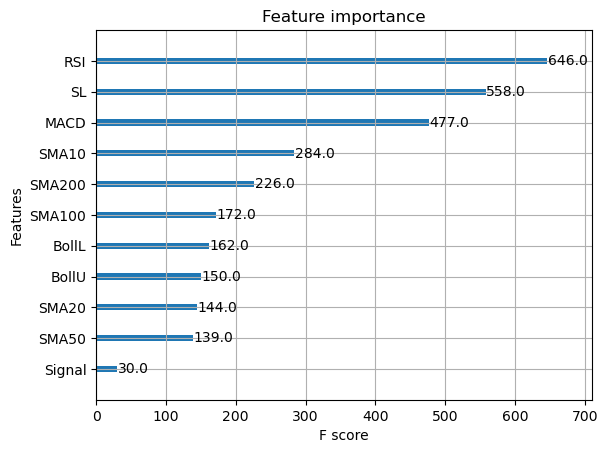

Balanced Accuracy Scores
--------------------------------------------------------
0.9333728015103362 training
0.6575233217639811 testing
0.2758494797463551 variance
--------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      4245
           1       0.57      0.35      0.43       563

    accuracy                           0.89      4808
   macro avg       0.74      0.66      0.69      4808
weighted avg       0.88      0.89      0.88      4808

--------------------------------------------------------


In [29]:
# Define the model
xgb_clf = XGBClassifier(random_state=1)

# Fit the model
xgb_clf.fit(X_train_scaled, y_train)

# Predict using the model
train_pred = xgb_clf.predict(X_train_scaled)
test_pred = xgb_clf.predict(X_test_scaled)

# Plot feature importance
from xgboost import plot_importance
plot_importance(xgb_clf)
plt.show()

# Generate classification report
# Print scores
print("Balanced Accuracy Scores")
print("--------------------------------------------------------")
x = balanced_accuracy_score(y_train, train_pred)
y = balanced_accuracy_score(y_test, test_pred)
print(balanced_accuracy_score(y_train, train_pred),'training')
print(balanced_accuracy_score(y_test, test_pred),'testing')
print(round((x-y), 16),'variance')

# Print classification reports
print("--------------------------------------------------------")
print(f"Classification Report")
report = classification_report(y_test, test_pred, zero_division=1)
print(report)
print("--------------------------------------------------------")

## Under Sampled Scaled Data and Untuned XGBoost Classifier

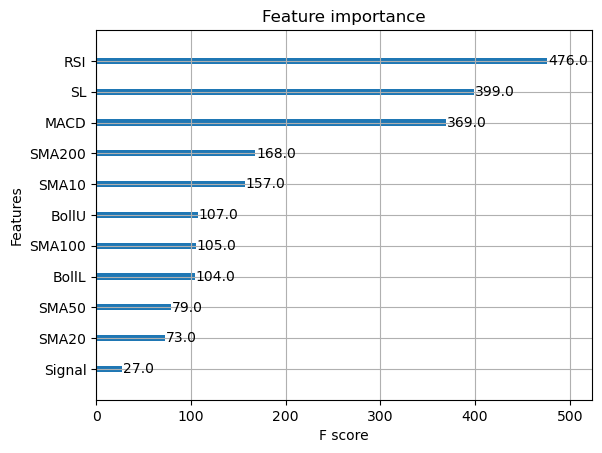

Balanced Accuracy Scores
--------------------------------------------------------
0.9305173401817843 training
0.9226550094458636 testing
0.0078623307359207 variance
--------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      4245
           1       0.55      0.95      0.70       563

    accuracy                           0.90      4808
   macro avg       0.77      0.92      0.82      4808
weighted avg       0.94      0.90      0.91      4808

--------------------------------------------------------


In [30]:
# Define the model
xgb_rus_clf = XGBClassifier(random_state=1)

# Fit the model
xgb_rus_clf.fit(X_undersampled, y_undersampled)

# Predict using the model
train_pred = xgb_rus_clf.predict(X_train_scaled)
test_pred = xgb_rus_clf.predict(X_test_scaled)

# Plot feature importance
plot_importance(xgb_rus_clf)
plt.show()

# Generate classification report
# Print scores
print("Balanced Accuracy Scores")
print("--------------------------------------------------------")
x = balanced_accuracy_score(y_train, train_pred)
y = balanced_accuracy_score(y_test, test_pred)
print(balanced_accuracy_score(y_train, train_pred),'training')
print(balanced_accuracy_score(y_test, test_pred),'testing')
print(round((x-y), 16),'variance')

# Print classification reports
print("--------------------------------------------------------")
print(f"Classification Report")
report = classification_report(y_test, test_pred, zero_division=1)
print(report)
print("--------------------------------------------------------")

## Under Sampled Scaled Data with XGBoost Parameter Tuning

In [31]:
# Try the following values for learning_rate
rate = np.arange(0.01, 1.1, 0.01)
models = {'train_score': [], 'test_score': [], 'learning_rate': []}

# Loop through each value in learning_rates
for r in rate:
    # Initialize the classifier with parameter variables
    xgb_rus_clf = XGBClassifier(learning_rate = r, tree_method='approx', random_state=1)

    # Fit the undersampled data the new model
    xgb_rus_clf.fit(X_undersampled, y_undersampled)

    # Make predictions
    train_pred = xgb_rus_clf.predict(X_train_scaled)
    test_pred = xgb_rus_clf.predict(X_test_scaled)

    # Calculate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['learning_rate'].append(r)

# Create a dataframe from the models dictionary with learning_rate as the index
models_df = pd.DataFrame(models).set_index('learning_rate')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(3))

,train_score,test_score
learning_rate,,
0.05,0.921552,0.943272
0.02,0.921310,0.940372
0.16,0.924665,0.938532


In [32]:
# Sort the dataframe by test_score in descending order and get the top 3
top_learning_rates = models_df.sort_values(by='test_score', ascending=False).head(3).index.tolist()

# Display the top 3 
top_learning_rates

[0.05, 0.02, 0.16]

<Axes: xlabel='learning_rate'>

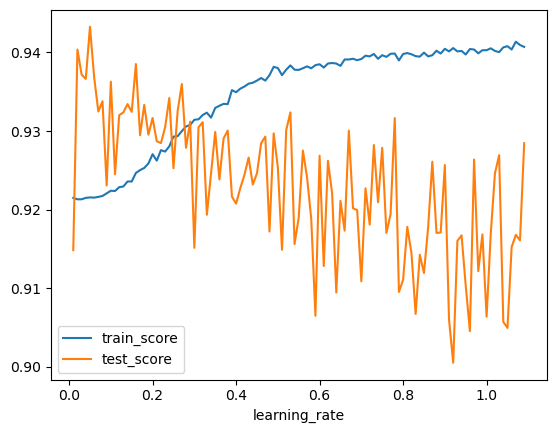

In [33]:
# Plot the results
models_df.plot()

In [34]:
# Try the following values for n_estimators
estimators = range(100, 200, 1)
models = {'train_score': [], 'test_score': [], 'n_estimators': []}

# Loop through each value in n_estimators
for n in estimators:
    # Initialize the classifier with parameter variables
    xgb_rus_clf = XGBClassifier(n_estimators = n, tree_method='approx', random_state=1)

    # Fit the undersampled data the new model
    xgb_rus_clf.fit(X_undersampled, y_undersampled)

    # Make predictions
    train_pred = xgb_rus_clf.predict(X_train_scaled)
    test_pred = xgb_rus_clf.predict(X_test_scaled)

    # Calculate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['n_estimators'].append(n)

# Create a dataframe from the models dictionary with n_estimators as the index
models_df = pd.DataFrame(models).set_index('n_estimators')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(3))

,train_score,test_score
n_estimators,,
161,0.935634,0.919220
130,0.933579,0.918985
138,0.934214,0.918332


In [35]:
# Sort the dataframe by test_score in descending order and get the top 3
top_n_estimators = models_df.sort_values(by='test_score', ascending=False).head(3).index.tolist()

# Display the top 3
top_n_estimators

[161, 130, 138]

<Axes: xlabel='n_estimators'>

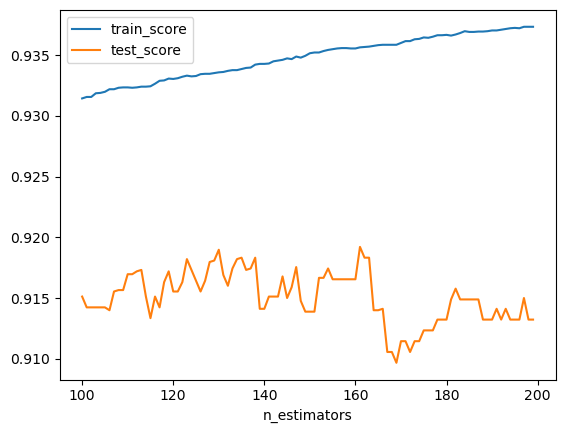

In [36]:
# Plot the results
models_df.plot()

In [37]:
# Try the following values for max_depth
max_depths = range(1, 30)
models = {'train_score': [], 'test_score': [], 'max_depth': []}

# Loop through each value in max_depths
for depth in max_depths:
    # Initialize the classifier with parameter variables
    xgb_rus_clf = XGBClassifier(max_depth = depth, tree_method='approx', random_state=1)
    
    # Fit the undersampled data the new model
    xgb_rus_clf.fit(X_undersampled, y_undersampled)

    # Make predictions
    train_pred = xgb_rus_clf.predict(X_train_scaled)
    test_pred = xgb_rus_clf.predict(X_test_scaled)

    # Caclulate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['max_depth'].append(depth)

# Create a dataframe from the models dictionary with max_depth as the index
models_df = pd.DataFrame(models).set_index('max_depth')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(3))

,train_score,test_score
max_depth,,
1,0.921189,0.944876
15,0.938263,0.934509
2,0.921396,0.934328


In [38]:
# Sort the dataframe by test_score in descending order and get the top 3
top_max_depth = models_df.sort_values(by='test_score', ascending=False).head(3).index.tolist()

# Display the top 3
top_max_depth

[1, 15, 2]

<Axes: xlabel='max_depth'>

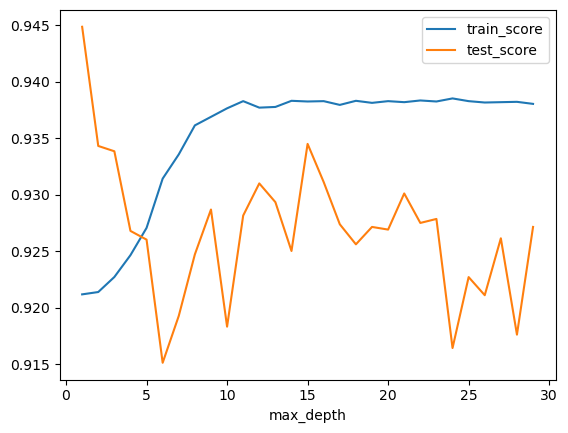

In [39]:
# Plot the results
models_df.plot()

In [40]:
# Try the following values for max_leaves
max_leaves = range(1, 30)
models = {'train_score': [], 'test_score': [], 'max_leaves': []}

# Loop through each value in max_depths
for leaf in max_leaves:
    # Initialize the classifier with parameter variables
    xgb_rus_clf = XGBClassifier(max_leaves = leaf, tree_method='approx', random_state=1)
    
    # Fit the undersampled data the new model
    xgb_rus_clf.fit(X_undersampled, y_undersampled)

    # Make predictions
    train_pred = xgb_rus_clf.predict(X_train_scaled)
    test_pred = xgb_rus_clf.predict(X_test_scaled)

    # Caclulate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['max_leaves'].append(leaf)

# Create a dataframe from the models dictionary with max_depth as the index
models_df = pd.DataFrame(models).set_index('max_leaves')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(3))

,train_score,test_score
max_leaves,,
2,0.921189,0.944876
3,0.921371,0.942919
4,0.921582,0.934092


In [41]:
# Sort the dataframe by test_score in descending order and get the top 3
top_max_leaves = models_df.sort_values(by='test_score', ascending=False).head(3).index.tolist()

# Display the top 3
top_max_leaves

[2, 3, 4]

<Axes: xlabel='max_leaves'>

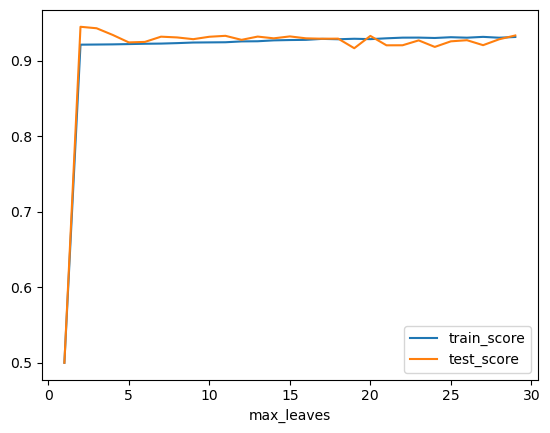

In [42]:
# Plot the results
models_df.plot()

In [43]:
# Try the following values for subsample
subsample = np.arange(0, 1, .01)
models = {'train_score': [], 'test_score': [], 'subsample': []}

# Loop through each value in max_depths
for sample in subsample:
    # Initialize the classifier with parameter variables
    xgb_rus_clf = XGBClassifier(subsample = sample, tree_method='approx', random_state=1)
    
    # Fit the undersampled data the new model
    xgb_rus_clf.fit(X_undersampled, y_undersampled)

    # Make predictions
    train_pred = xgb_rus_clf.predict(X_train_scaled)
    test_pred = xgb_rus_clf.predict(X_test_scaled)

    # Caclulate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['subsample'].append(sample)

# Create a dataframe from the models dictionary with max_depth as the index
models_df = pd.DataFrame(models).set_index('subsample')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(3))

,train_score,test_score
subsample,,
0.01,0.904863,0.940907
0.51,0.933237,0.935216
0.87,0.933851,0.935098


In [44]:
# Sort the dataframe by test_score in descending order and get the top 3
top_subsample = models_df.sort_values(by='test_score', ascending=False).head(3).index.tolist()

# Display the top 3
top_subsample

[0.01, 0.51, 0.87]

<Axes: xlabel='subsample'>

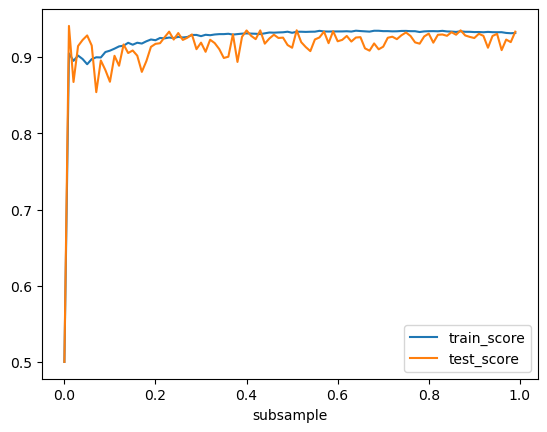

In [45]:
# Plot the results
models_df.plot()

In [46]:
# Dictionary with 3 values for each parameter
params = {
    'n_estimators': top_n_estimators,
    'max_depth': top_max_depth,
    'learning_rate': top_learning_rates,
    'max_leaves': top_max_leaves,
    'subsample': top_subsample
}

# Initialize a dictionary to store results
results = {'n_estimators': [], 'max_depth': [], 'learning_rate': [],'max_leaves': [], 'subsample': [], 'train_score': [], 'test_score': []}

# Loop through all combinations of parameters
for n in params['n_estimators']:
    for d in params['max_depth']:
        for lr in params['learning_rate']:
            for ml in params['max_leaves']:
                for s in params['subsample']:
                    # Initialize the classifier with current parameters
                    xgb_rus_clf = XGBClassifier(n_estimators=n, learning_rate=lr, max_depth=d, max_leaves=ml, subsample=s, tree_method='approx', random_state=1)
                
                    # Fit the undersampled data
                    xgb_rus_clf.fit(X_undersampled, y_undersampled)
    
                    # Make predictions
                    train_pred = xgb_rus_clf.predict(X_train_scaled)
                    test_pred = xgb_rus_clf.predict(X_test_scaled)
    
                    # Calculate balanced accuracy scores
                    train_score = balanced_accuracy_score(y_train, train_pred)
                    test_score = balanced_accuracy_score(y_test, test_pred)
    
                    # Append results to the dictionary
                    results['n_estimators'].append(n)
                    results['max_depth'].append(d)
                    results['learning_rate'].append(lr)
                    results['max_leaves'].append(ml)
                    results['subsample'].append(s)
                    results['train_score'].append(train_score)
                    results['test_score'].append(test_score)

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results)

In [47]:
sorted_results_df = results_df.sort_values(by='test_score', ascending=False)
print(sorted_results_df.head(3))

     n_estimators  max_depth  learning_rate  max_leaves  subsample  \
239           138          2           0.16           3       0.87   
212           138         15           0.16           3       0.87   
131           130         15           0.16           3       0.87   

     train_score  test_score  
239      0.92128    0.944994  
212      0.92128    0.944994  
131      0.92122    0.944994  


In [48]:
# For Classification
# Initialize the classifier with current parameters
xgb_rus_clf = XGBClassifier(n_estimators=162, max_depth=15, learning_rate=.02, max_leaves=29, subsample=.43, tree_method='approx', min_split_loss=0, min_child_weight=1, random_state=1)

# Fit the undersampled data
xgb_rus_clf.fit(X_undersampled, y_undersampled)

# Make predictions
train_pred = xgb_rus_clf.predict(X_train_scaled)
test_pred = xgb_rus_clf.predict(X_test_scaled)

# Generate classification report
# Print scores
print("Balanced Accuracy Scores")
print("--------------------------------------------------------")
x = balanced_accuracy_score(y_train, train_pred)
y = balanced_accuracy_score(y_test, test_pred)
print(balanced_accuracy_score(y_train, train_pred),'training score')
print(balanced_accuracy_score(y_test, test_pred),'testing score')
print(round((x-y), 16),'variance')

# Print classification reports
print("--------------------------------------------------------")
print(f"Classification Report - Original Data")
print(classification_report(y_test, test_pred))
print("--------------------------------------------------------")

Balanced Accuracy Scores
--------------------------------------------------------
0.9211894113380877 training score
0.9451118963486455 testing score
-0.0239224850105577 variance
--------------------------------------------------------
Classification Report - Original Data
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      4245
           1       0.55      1.00      0.71       563

    accuracy                           0.90      4808
   macro avg       0.77      0.95      0.82      4808
weighted avg       0.95      0.90      0.91      4808

--------------------------------------------------------


## Original Scaled Data and Untuned LightBoost

In [49]:
# Define model
lgb_clf = lgb.LGBMClassifier(random_state=1, verbose=-1)

# Fit the model
lgb_clf.fit(X_train_scaled, y_train)

# Predict using the model
train_pred = lgb_clf.predict(X_train_scaled)
test_pred = lgb_clf.predict(X_test_scaled)

# Generate classification report
# Print scores
print("Balanced Accuracy Scores")
print("--------------------------------------------------------")
x = balanced_accuracy_score(y_train, train_pred)
y = balanced_accuracy_score(y_test, test_pred)
print(balanced_accuracy_score(y_train, train_pred),'training')
print(balanced_accuracy_score(y_test, test_pred),'testing')
print(round((x-y), 16),'variance')

# Print classification reports
print("--------------------------------------------------------")
print(f"Classification Report")
report = classification_report(y_test, test_pred, zero_division=1)
print(report)
print("--------------------------------------------------------")

Balanced Accuracy Scores
--------------------------------------------------------
0.8887294421139954 training
0.645978028691157 testing
0.2427514134228384 variance
--------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      4245
           1       0.55      0.33      0.41       563

    accuracy                           0.89      4808
   macro avg       0.73      0.65      0.68      4808
weighted avg       0.87      0.89      0.88      4808

--------------------------------------------------------


## Under Sampled Scaled Data with Untuned LightBoost

In [50]:
# Define model
lgb_rus_clf = lgb.LGBMClassifier(random_state=1, verbose=-1)

# Fit the model
lgb_rus_clf.fit(X_undersampled, y_undersampled)

# Predict using the model
train_pred = lgb_rus_clf.predict(X_train_scaled)
test_pred = lgb_rus_clf.predict(X_test_scaled)

# Generate classification report
# Print scores
print("Balanced Accuracy Scores")
print("--------------------------------------------------------")
x = balanced_accuracy_score(y_train, train_pred)
y = balanced_accuracy_score(y_test, test_pred)
print(balanced_accuracy_score(y_train, train_pred),'training')
print(balanced_accuracy_score(y_test, test_pred),'testing')
print(round((x-y), 16),'variance')

# Print classification reports
print("--------------------------------------------------------")
print(f"Classification Report")
report = classification_report(y_test, test_pred, zero_division=1)
print(report)
print("--------------------------------------------------------")

Balanced Accuracy Scores
--------------------------------------------------------
0.9251081778464767 training
0.9362850872513269 testing
-0.0111769094048502 variance
--------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      4245
           1       0.55      0.98      0.70       563

    accuracy                           0.90      4808
   macro avg       0.77      0.94      0.82      4808
weighted avg       0.94      0.90      0.91      4808

--------------------------------------------------------


## RandomUnderSampler Data with Tuned Lightboost Classifier

In [67]:
rates = np.arange(0.05, 1.0, 0.01)
models = {'train_score': [], 'test_score': [], 'learning_rate': []}

# Loop through each value in rates
for r in rates:
    # Initialize the classifier with current parameters
    lgb_rus_clf = lgb.LGBMClassifier(learning_rate=r, random_state=1, verbose=-1)

    # Fit the undersampled data
    lgb_rus_clf.fit(X_undersampled, y_undersampled)

    # Make predictions
    train_pred = lgb_rus_clf.predict(X_train)
    test_pred = lgb_rus_clf.predict(X_test)

    # Calculate balanced accuracy score
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['learning_rate'].append(r)

# Create a dataframe from the models dictionary with learning_rate as the index
models_df = pd.DataFrame(models).set_index('learning_rate')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(3))

,train_score,test_score
learning_rate,,
0.99,0.898765,0.945347
0.94,0.919344,0.944994
0.11,0.921189,0.944876


In [68]:
rates = np.arange(0.05, 1.0, 0.01)
models = {'train_score': [], 'test_score': [], 'learning_rate': []}

# Loop through each value in rates
for r in rates:
    # Initialize the classifier with current parameters
    lgb_rus_clf = lgb.LGBMClassifier(learning_rate=r, random_state=1, verbose=-1)

    # Fit the undersampled data
    lgb_rus_clf.fit(X_undersampled, y_undersampled)

    # Make predictions
    train_pred = lgb_rus_clf.predict(X_train)
    test_pred = lgb_rus_clf.predict(X_test)

    # Calculate balanced accuracy score
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['learning_rate'].append(r)

# Create a dataframe from the models dictionary with learning_rate as the index
models_df = pd.DataFrame(models).set_index('learning_rate')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(3))

,train_score,test_score
learning_rate,,
0.99,0.898765,0.945347
0.94,0.919344,0.944994
0.11,0.921189,0.944876


In [ ]:
# Sort the dataframe by test_score in descending order and get the top 5
learning_rate = models_df.sort_values(by='test_score', ascending=False).head(5).index.tolist()

# Display the top 5 max_depths
learning_rate

<Axes: xlabel='learning_rate'>

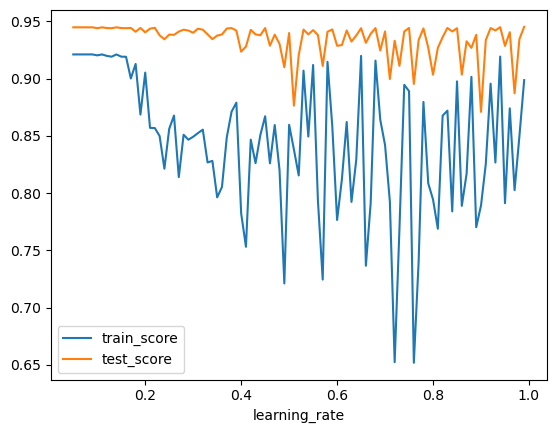

In [69]:
# Plot the results
models_df.plot()

In [70]:
# Try the following values for n_estimators
estimators = range(100, 250, 1)
models = {'train_score': [], 'test_score': [], 'n_estimators': []}

# Loop through each value in n_estimators
for n in estimators:
    # Initialize the classifier with current parameters
    lgb_rus_clf =lgb.LGBMClassifier(n_estimators = n, random_state=1, verbose=-1)

    # Fit the undersampled data
    lgb_rus_clf.fit(X_undersampled, y_undersampled)

    # Make predictions
    train_pred = lgb_rus_clf.predict(X_train)
    test_pred = lgb_rus_clf.predict(X_test)

    # Calculate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['n_estimators'].append(n)

# Create a dataframe from the models dictionary with n_estimators as the index
models_df = pd.DataFrame(models).set_index('n_estimators')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(3))

,train_score,test_score
n_estimators,,
234,0.902659,0.944577
222,0.904409,0.944577
224,0.902287,0.944577


In [71]:
# Sort the dataframe by test_score in descending order and get the top 3
n_estimators = models_df.sort_values(by='test_score', ascending=False).head(3).index.tolist()

# Display the top 3
n_estimators

[234, 222, 224]

<Axes: xlabel='n_estimators'>

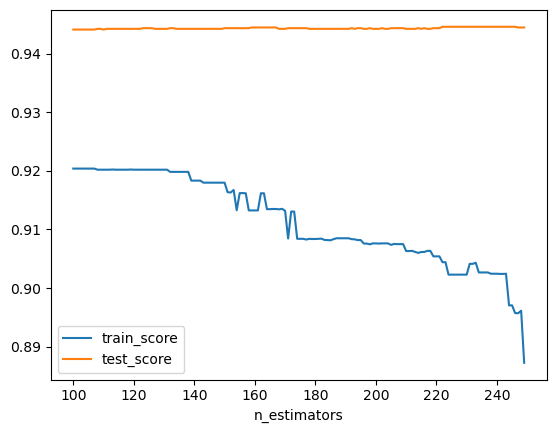

In [72]:
# Plot the results
models_df.plot()

In [73]:
# Try the following values for max_depth
max_depths = range(2, 30)
models = {'train_score': [], 'test_score': [], 'max_depth': []}

# Loop through each value in max_depths
for depth in max_depths:
    # Initialize the classifier with current parameters
    lgb_rus_clf = lgb.LGBMClassifier(max_depth = depth, random_state=1, verbose=-1)
    
    # Fit the undersampled data
    lgb_rus_clf.fit(X_undersampled, y_undersampled)

    # Make predictions
    train_pred = lgb_rus_clf.predict(X_train)
    test_pred = lgb_rus_clf.predict(X_test)

    # Calculate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)
 
    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['max_depth'].append(depth)

# Create a dataframe from the models dictionary with max_depth as the index
models_df = pd.DataFrame(models).set_index('max_depth')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(3))

,train_score,test_score
max_depth,,
21,0.921189,0.944994
19,0.920475,0.944994
11,0.920878,0.944994


In [74]:
# Sort the dataframe by test_score in descending order and get the top 3
max_depth = models_df.sort_values(by='test_score', ascending=False).head(3).index.tolist()

# Display the top 3 
max_depth

[21, 19, 11]

<Axes: xlabel='max_depth'>

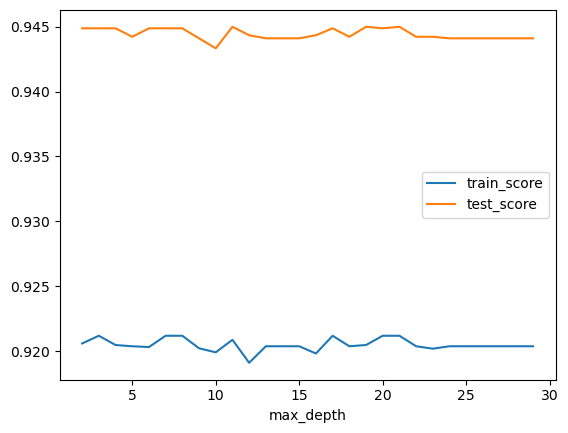

In [75]:
# Plot the results
models_df.plot()

In [76]:
# Try the following values for num_leaves
num_leaves = range(10, 50)
models = {'train_score': [], 'test_score': [], 'num_leaves': []}

# Loop through each value in num_leaves
for num in num_leaves:
    # Initialize the classifier with current parameters
    lgb_rus_clf = lgb.LGBMClassifier(num_leaves = num, random_state=1, verbose=-1)
    
    # Fit the undersampled data
    lgb_rus_clf.fit(X_undersampled, y_undersampled)

    # Make predictions
    train_pred = lgb_rus_clf.predict(X_train)
    test_pred = lgb_rus_clf.predict(X_test)

    # Calculate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)
 
    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['num_leaves'].append(num)

# Create a dataframe from the models dictionary with max_depth as the index
models_df = pd.DataFrame(models).set_index('num_leaves')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(3))

,train_score,test_score
num_leaves,,
26,0.920847,0.944994
41,0.920847,0.944876
12,0.921220,0.944876


In [77]:
# Sort the dataframe by test_score in descending order and get the top 3
num_leaves = models_df.sort_values(by='test_score', ascending=False).head(3).index.tolist()

# Display the top 3 
num_leaves

[26, 41, 12]

<Axes: xlabel='num_leaves'>

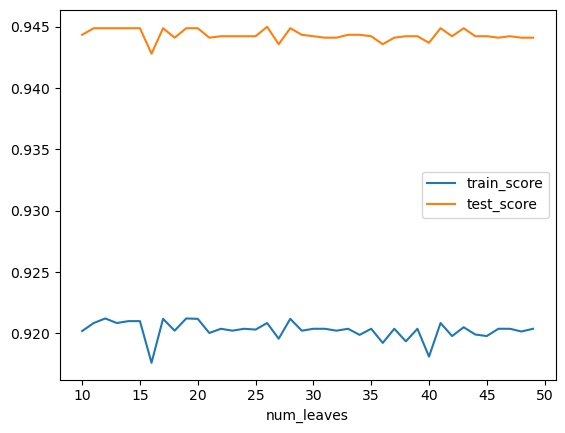

In [78]:
# Plot the results
models_df.plot()

In [79]:
# Try the following values for max_bin
max_bin = range(20, 512, 1)
models = {'train_score': [], 'test_score': [], 'max_bin': []}

# Loop through each value in max_bins
for bin in max_bin:
    # Initialize the classifier with current parameters
    lgb_rus_clf = lgb.LGBMClassifier(max_bin = bin, random_state=1, verbose=-1)
    
    # Fit the undersampled data
    lgb_rus_clf.fit(X_undersampled, y_undersampled)

    # Make predictions
    train_pred = lgb_rus_clf.predict(X_train)
    test_pred = lgb_rus_clf.predict(X_test)

    # Calculate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)
 
    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['max_bin'].append(bin)

# Create a dataframe from the models dictionary with max_depth as the index
models_df = pd.DataFrame(models).set_index('max_bin')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(3))

,train_score,test_score
max_bin,,
264,0.920475,0.944994
465,0.920319,0.944994
290,0.920847,0.944994


In [80]:
# Sort the dataframe by test_score in descending order and get the top 3
max_bin = models_df.sort_values(by='test_score', ascending=False).head(3).index.tolist()

# Display the top 3 
max_bin

[264, 465, 290]

<Axes: xlabel='max_bin'>

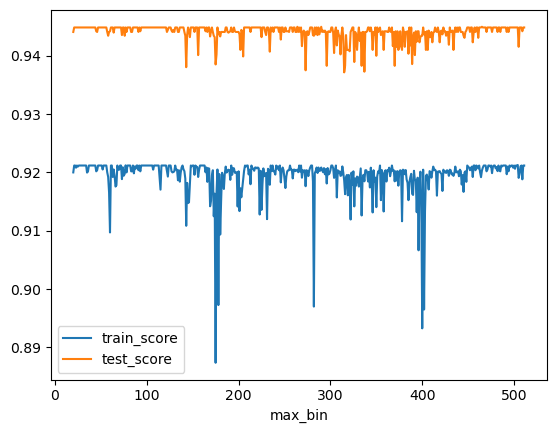

In [81]:
# Plot the results
models_df.plot()

In [82]:
# Dictionary with 3 values for each parameter
params = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'learning_rate': learning_rate,
    'num_leaves': num_leaves,
    'max_bin': max_bin
}

# Initialize a dictionary to store results
results = {'n_estimators': [], 'max_depth': [], 'learning_rate': [], 'num_leaves': [], 'max_bin': [], 'train_score': [], 'test_score': []}

# Loop through all combinations of parameters
for n in params['n_estimators']:
    for d in params['max_depth']:
        for lr in params['learning_rate']:
            for nl in params['num_leaves']:
                for b in params['max_bin']:
                    # Initialize the classifier with current parameters
                    lgb_rus_clf = lgb.LGBMClassifier(n_estimators=n, learning_rate=lr, max_depth=d, num_leaves=nl, max_bin=b, random_state=1, verbose=-1)
                
                    # Fit the undersampled data
                    lgb_rus_clf.fit(X_undersampled, y_undersampled)
    
                    # Make predictions
                    train_pred = lgb_rus_clf.predict(X_train)
                    test_pred = lgb_rus_clf.predict(X_test)
    
                    # Calculate balanced accuracy scores
                    train_score = balanced_accuracy_score(y_train, train_pred)
                    test_score = balanced_accuracy_score(y_test, test_pred)
    
                    # Append results to the dictionary
                    results['n_estimators'].append(n)
                    results['max_depth'].append(d)
                    results['learning_rate'].append(lr)
                    results['num_leaves'].append(nl)
                    results['max_bin'].append(b)
                    results['train_score'].append(train_score)
                    results['test_score'].append(test_score)
                    
# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results)

NameError: name 'learning_rate' is not defined

In [ ]:
sorted_results_df = results_df.sort_values(by='test_score', ascending=False)
print(sorted_results_df.head(3))

In [ ]:
# For Classification
# Initialize the classifier with current parameters
lgb_rus_clf = lgb.LGBMClassifier(n_estimators=105, max_depth=16, learning_rate=.06, num_leaves=22, max_bin=67, random_state=1, verbose=-1)

# Fit the undersampled data
lgb_rus_clf.fit(X_undersampled, y_undersampled)

In [ ]:
# Make predictions
train_pred = lgb_rus_clf.predict(X_train)
test_pred = lgb_rus_clf.predict(X_test)

In [ ]:
# Check the model's balanced accuracy on the training and test sets
print('\nRandomUnderSampled Data and Tuned LGB Classifer')

# Print scores
print("--------------------------------------------------------")
x = balanced_accuracy_score(y_train, train_pred)
y = balanced_accuracy_score(y_test, test_pred)
print(balanced_accuracy_score(y_train, train_pred),'training score')
print(balanced_accuracy_score(y_test, test_pred),'testing score')
print(round((x-y), 16),'variance')

# Print classification reports
print("--------------------------------------------------------")
print(f"Classification Report - Original Data")
print(classification_report(y_test, test_pred))
print("--------------------------------------------------------")

In [ ]:
# Get the feature importance array
importances = lgb_rus_clf.feature_importances_
# List the top 10 most important features
importances_sorted = sorted(zip(lgb_rus_clf.feature_importances_, X.columns), reverse=True)
importances_sorted